# Document Classification with CNN [Part 3] - Model Building

* Solved By: Pradip Dharam
* Objective: Preprocess docs, train multiple ConvNets to classify docs with achieve upto 70% accuracy etc.
* Part 1 [Another Notebook]: Preprocessing of all 18828 files. Features preprocessed_email, preprocessed_subjects, preprocessed_texts to be extracted.
* Part 2 [Another Notebook]: Multiple ConvNets models to be trained.
* Part 3 [Covered]: Multiple ConvNets models to be trained. Another architecture than previous.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf. __version__) 

Num GPUs Available:  1
2.7.0


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

import matplotlib
import tkinter
#matplotlib.use('TkAgg')
#matplotlib.use('Agg')
#import probscale
import seaborn as sns

In [3]:
from tensorflow import keras 
from tensorflow.keras import Sequential, Model

In [4]:
import tensorflow.compat.v2 as tf
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, Flatten, Embedding, LSTM 
from tensorflow.keras.layers import concatenate, Dropout, Conv1D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import tensorflow_addons as tfa

import tensorflow as tf
import datetime
import time as time

In [5]:
#!pip install tensorflow-addons

In [6]:
#"UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure."
#!pip install pyqt5

## Train Test Splits - Stratified

In [7]:
df = pd.read_excel("Preprocessed_Documents_60778.xlsx")

In [8]:
df['combined'] = df.preprocessed_text + ' ' + df.preprocessed_subject + ' ' + df.preprocessed_emails

In [9]:
df.drop(['Unnamed: 0', 'document_name', 'text', 'preprocessed_text',
       'preprocessed_subject', 'preprocessed_emails'], axis=1, inplace=True)

In [10]:
df.columns

Index(['class', 'combined'], dtype='object')

In [11]:
df['class'].isna().sum()

0

In [12]:
df.isna().sum()

class         0
combined    129
dtype: int64

In [13]:
df.shape

(18828, 2)

In [14]:
df = df[pd.notnull(df['combined'])].reset_index().filter(['combined', 'class'])
df

,combined,class
0,atheism resources resources december atheist r...,alt.atheism
1,atheism introduction introduction april begin ...,alt.atheism
2,article well has quite different not necessari...,alt.atheism
3,recently ras have been ordered and none have r...,alt.atheism
4,article however hate economic terrorism and po...,alt.atheism
...,...,...
18694,was not sure this was the right newsgroup post...,talk.religion.misc
18695,article article probably not but then not pack...,talk.religion.misc
18696,article you would like understand better the s...,talk.religion.misc
18697,article the danger anti cult groups that while...,talk.religion.misc


In [15]:
df.shape

(18699, 2)

In [16]:
df.isna().sum()

combined    0
class       0
dtype: int64

In [17]:
X = df['combined']
y = df['class']
print(X.shape)
print(y.shape, y[0])

(18699,)
(18699,) alt.atheism


In [18]:
X.isna().sum()

0

In [19]:
type(X)

pandas.core.series.Series

In [20]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("train_index:", train_index, "test_index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.25,
            train_size=None)
train_index: [15109 10406  9947 ... 10668  3767 16491] test_index: [  138  2914 17633 ... 14323 12225  8836]
train_index: [ 4222  6505  2178 ... 12066 13209  7769] test_index: [18612   968   514 ...  1585 18418  3229]


In [21]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(14024,) (4675,)
(14024,) (4675,)


### Plotting class distributions

In [22]:
def plot_class_counts_histogrem(y_train):
    dict_class_counts = dict(Counter(y_train))
    class_document_counts = pd.Series(dict_class_counts)
    #https://stackoverflow.com/questions/29525120/pandas-creating-a-histogram-from-string-counts
    plt.bar(range(len(class_document_counts)), \
            class_document_counts.values, align='center')
    plt.xticks(range(len(class_document_counts)), \
               class_document_counts.index.values, size='large', rotation='vertical')
    plt.show()

#### Train Set

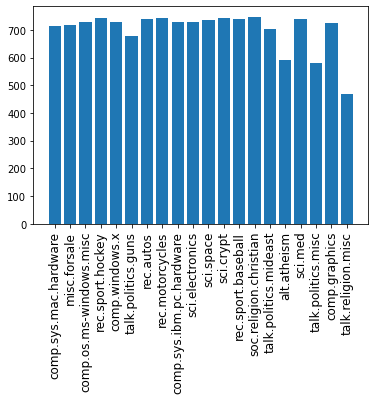

In [23]:
plot_class_counts_histogrem(Y_train)

#### Test Set

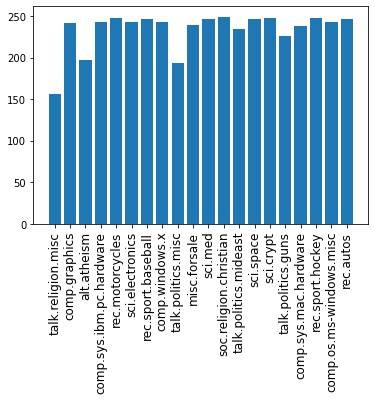

In [24]:
plot_class_counts_histogrem(Y_test)

Distribution of classes across train and test sets looks similar

## Analyzing prepeocessed text
We should check X_train only to avoid the data leakage. X_train here in concatenation of features preprocessed_text, df.preprocessed_subject and preprocessed_emails.

### Texts sequence lengths analysis

In [25]:
X_train[0][0:100]

'atheism resources resources december atheist resources addresses atheist organizations usa freedom f'

In [26]:
len(X_train[0]) #Number of character in X_train[0]

8139

In [27]:
#Number of words in each sequence
#text_lengths = pd.Series([len(sequence.split()) for sequence in X_train])

#Number of characters in each sequence
text_lengths = pd.Series([len(sequence) for sequence in X_train])
text_lengths

0         418
1         225
2         290
3         112
4         404
         ... 
14019     391
14020    1597
14021    1287
14022     308
14023    1239
Length: 14024, dtype: int64

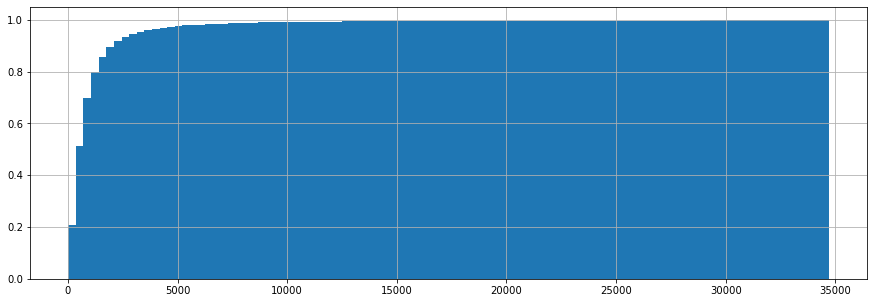

In [28]:
def plot_percentiles(numbers):
    #https://stackoverflow.com/questions/25577352/plotting-cdf-of-a-pandas-series-in-python
    fig = plt.figure(figsize = (15,5))
    ax = fig.gca()
    numbers.hist(ax = ax, cumulative=True, density=1, bins=100)

plot_percentiles(text_lengths)

In [29]:
text_lengths.quantile(q=0.85)

1693.5499999999993

In [30]:
text_lengths.quantile(q=.9)

2154.7000000000007

In [31]:
text_lengths.quantile(q=.95)

3336.0

In [32]:
text_lengths.quantile(q=.99)

8852.640000000014

85% of the records or sequences are below the length 2154

In [33]:
max_sequence_length = 2154

#### Function to convert scentense to chars sequence

In [34]:
def convert_scentense_to_chars(s):
    s = "".join(s.split())
    s = list(s)
    s = ' '.join(s)
    return s

s = 'have had running with mhz osc for'
convert_scentense_to_chars(s)

'h a v e h a d r u n n i n g w i t h m h z o s c f o r'

In [35]:
X_train[10]

'how long does the motto have stay around before becomes the default where the cutoff point not know where the exact cutoff but least after few years and surely after years why does the notion default not take into account changes population makeup specifically which changes are you talking about are you arguing that the motto interpreted offensive larger portion the population now than years ago keith Pompous ass cco caltech edu solntze wpd sgi'

In [36]:
convert_scentense_to_chars(X_train[10])

'h o w l o n g d o e s t h e m o t t o h a v e s t a y a r o u n d b e f o r e b e c o m e s t h e d e f a u l t w h e r e t h e c u t o f f p o i n t n o t k n o w w h e r e t h e e x a c t c u t o f f b u t l e a s t a f t e r f e w y e a r s a n d s u r e l y a f t e r y e a r s w h y d o e s t h e n o t i o n d e f a u l t n o t t a k e i n t o a c c o u n t c h a n g e s p o p u l a t i o n m a k e u p s p e c i f i c a l l y w h i c h c h a n g e s a r e y o u t a l k i n g a b o u t a r e y o u a r g u i n g t h a t t h e m o t t o i n t e r p r e t e d o f f e n s i v e l a r g e r p o r t i o n t h e p o p u l a t i o n n o w t h a n y e a r s a g o k e i t h P o m p o u s a s s c c o c a l t e c h e d u s o l n t z e w p d s g i'

#### Converting entire X_train and X_test to sequences of characters

In [37]:
X_train = [convert_scentense_to_chars(scentense) for scentense in X_train]
X_test  = [convert_scentense_to_chars(scentense) for scentense in X_test]

In [38]:
X_train[0:1]

['h a v e h a d r u n n i n g w i t h m h z o s c f o r f e w m o n t h s h a v e n u m b e r s c s i d e v i c e s c o n n e c t e d q u a n t u m m a x t o r t o s h i b a m k f v i a e m u l e x a d a p t e r p i o n e e r d r m a n d h a v e h a d t r o u b l e t h i s b e i n g d o n e w i t h t h e m o t h e r b o a r d s c s i i n t e r f a c e t h i s p o s s i b l e t h e n b i t e x p e r i m e n t i n g w i t h j u s t p l a i n o l d c l o c k o s c i l l a t o r s m a y o r d e r g i v e s o m e m o r e d e t a i l s p l e a s e t h e m a d c l o c k c h i p p e r s e a t t l e Q 7 0 0 a t 3 4 5 M H z i t s f i n e c a r s o n w a s h i n g t o n e d u w a s h i n g t o n e d u']

### Checking the counts of each unique word in the combined prepeocessed text

In [39]:
scalar = TfidfVectorizer(ngram_range=(1, 1), use_idf=True, 
                         token_pattern='(?u)\\b\\w+\\b') #in scikit-learn

#https://stackoverflow.com/questions/48984071/scikit-tf-idf-empty-vocabulary
#token_pattern='(?u)\\b\\w+\\b'
#This is to solve error "TF-IDF empty vocabulary" since TfidfVectorizer does not accept short words
#Here one word is one character itself.

tfidf  = scalar.fit_transform(X_train)

In [40]:
vocab_data = scalar.get_feature_names()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
print(vocab_data)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ï']


In [42]:
len(vocab_data)

38

### Creating zero padded sequences of numbers

I am going to incorporate similar vectorize_layer while creating actual model

This is how the vectorize_layer works!

In [43]:
#vocab_data_sample = ["foo", "bar", "baz"]
#list(vocab_data_sample)

In [44]:
#Keras documentation itself
#https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/
#This is not the exact copied code, its modified after.

vocab_data_sample = ['f', 'o','a','r', 'b','z']
max_features = len(vocab_data_sample) + 2 # Maximum vocab size.
max_len = 5  # Sequence length to pad the outputs to.

# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = tf.keras.layers.TextVectorization(
                    max_tokens=max_features,
                    output_mode='int',
                    output_sequence_length=max_len,
                    vocabulary=vocab_data_sample)



 # Because we've passed the vocabulary directly, we don't need to adapt
 # the layer - the vocabulary is already set. The vocabulary contains the
 # padding token ('') and OOV token ('[UNK]') as well as the passed tokens.
vectorize_layer.get_vocabulary()
#['', '[UNK]', 'earth', 'wind', 'and', 'fire']

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["f o o q u x b a r h e l l o"], ["q u x b a z"], ["f o o q u x b a r h e l l o q u x b a z"]]
model.predict(input_data)

array([[2, 3, 3, 1, 1],
       [1, 1, 1, 6, 4],
       [2, 3, 3, 1, 1]], dtype=int64)

Lets check on actual dataset

In [45]:
#print(vocab_data)

In [46]:
#Keras documentation itself
#https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/

#vocab_data - unique words in training dataset
max_features = len(vocab_data) + 2 # Maximum vocab size.
#max_len = max_sequence_length  # Sequence length to pad the outputs to.

# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = tf.keras.layers.TextVectorization(
max_tokens=max_features,
output_mode='int',
output_sequence_length=max_sequence_length,
vocabulary=vocab_data)

 # Because we've passed the vocabulary directly, we don't need to adapt
 # the layer - the vocabulary is already set. The vocabulary contains the
 # padding token ('') and OOV token ('[UNK]') as well as the passed tokens.
vectorize_layer.get_vocabulary()
#['', '[UNK]', 'earth', 'wind', 'and', 'fire']

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

print(X_train[0:5])
temp_sequences = model.predict(X_train[0:5])
print(temp_sequences)

['h a v e h a d r u n n i n g w i t h m h z o s c f o r f e w m o n t h s h a v e n u m b e r s c s i d e v i c e s c o n n e c t e d q u a n t u m m a x t o r t o s h i b a m k f v i a e m u l e x a d a p t e r p i o n e e r d r m a n d h a v e h a d t r o u b l e t h i s b e i n g d o n e w i t h t h e m o t h e r b o a r d s c s i i n t e r f a c e t h i s p o s s i b l e t h e n b i t e x p e r i m e n t i n g w i t h j u s t p l a i n o l d c l o c k o s c i l l a t o r s m a y o r d e r g i v e s o m e m o r e d e t a i l s p l e a s e t h e m a d c l o c k c h i p p e r s e a t t l e Q 7 0 0 a t 3 4 5 M H z i t s f i n e c a r s o n w a s h i n g t o n e d u w a s h i n g t o n e d u', 'l o o k i n g f o r c o p y l a s t f i l m a n y o n e h a s c o p y t h i s s t i n k e r p l e a s e m a i l a l s o a n y o n e k n o w s b e t t e r p l a c e p o s t t h i s p l e a s e t e l l y o u a t e t h e o n l y t h i n g e v e r l o v e d P l a n 9 F r o m O u t e r S p a c e W A N

Below vocablary and sequences created will be used later

In [47]:
#This will be used to extract embedding vectors fro GloVe for each word in vocablary ...
# using the index of the word in this vocab_produced list
vocab_produced = vectorize_layer.get_vocabulary()

#This will be used as input to the keras Input later of the model.
x_train_sequences = model.predict(X_train)
x_test_sequences  = model.predict(X_test)

Create y_train

In [48]:
Y_train = Y_train.str.replace('-','_')
Y_train = Y_train.str.replace('.','_')

Y_test = Y_test.str.replace('-','_')
Y_test = Y_test.str.replace('.','_')

C:\Users\Pradip\AppData\Local\Temp/ipykernel_10164/2905364387.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Y_train = Y_train.str.replace('.','_')
C:\Users\Pradip\AppData\Local\Temp/ipykernel_10164/2905364387.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Y_test = Y_test.str.replace('.','_')


In [49]:
label_corpus = ' '.join([str(e) for e in Y_train.unique()])
print(label_corpus)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(Y_train)

comp_sys_mac_hardware misc_forsale comp_os_ms_windows_misc rec_sport_hockey comp_windows_x talk_politics_guns rec_autos rec_motorcycles comp_sys_ibm_pc_hardware sci_electronics sci_space sci_crypt rec_sport_baseball soc_religion_christian talk_politics_mideast alt_atheism sci_med talk_politics_misc comp_graphics talk_religion_misc


CountVectorizer()

In [50]:
y_train = vectorizer.transform(Y_train).toarray()
y_test  = vectorizer.transform(Y_test) .toarray()

In [51]:
y_train[0:5]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [52]:
Y_train[0:5]

4222      comp_sys_mac_hardware
6505               misc_forsale
2178    comp_os_ms_windows_misc
9774           rec_sport_hockey
4827             comp_windows_x
Name: class, dtype: object

In [53]:
vectorizer.get_feature_names_out()

array(['alt_atheism', 'comp_graphics', 'comp_os_ms_windows_misc',
       'comp_sys_ibm_pc_hardware', 'comp_sys_mac_hardware',
       'comp_windows_x', 'misc_forsale', 'rec_autos', 'rec_motorcycles',
       'rec_sport_baseball', 'rec_sport_hockey', 'sci_crypt',
       'sci_electronics', 'sci_med', 'sci_space',
       'soc_religion_christian', 'talk_politics_guns',
       'talk_politics_mideast', 'talk_politics_misc',
       'talk_religion_misc'], dtype=object)

Alternate approch to create right padded sequences of numbers.
* tf.keras "Tokenizer" API, it removes the "_"

In [54]:
'''
#Below approach also can be used to create the right padded sequences of numbers.
#Since I am going to use above vectorize_layer, below code I have not tested.
t = Tokenizer()
t.fit_on_texts(word_corpus)
vocab_size = len(t.word_index) + 1
print("Number of unique words: ", vocab_size)
# integer encode the documents
x_train = t.texts_to_sequences(X_train)
x_test  = t.texts_to_sequences(X_test)
'''

'\n#Below approach also can be used to create the right padded sequences of numbers.\n#Since I am going to use above vectorize_layer, below code I have not tested.\nt = Tokenizer()\nt.fit_on_texts(word_corpus)\nvocab_size = len(t.word_index) + 1\nprint("Number of unique words: ", vocab_size)\n# integer encode the documents\nx_train = t.texts_to_sequences(X_train)\nx_test  = t.texts_to_sequences(X_test)\n'

## Figuring out for models to be trained

##### getting my brain dirty, not hands! 

Metrics to be considered
* "categorical_crossentropy" as Loss
*  Accuracy and Micro Avgeraged F1 score as my as Key metrics to evaluate my model

Model weights and results visualization
* Tensorboard to plot the loss and Metrics based on the epoches
* I can save save my best model weights in to 'best_model_L.h5' ( L = 1 or 2 )
* I am going to save my model to image ( can plot the model) with shapes and inlcude those images in the notebook markdown cell. I can use "plot model"
* Plotting model with shapes can be checked here https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model

I need to decide below parameters
* Activation function, learning rate, optimizer.

Early Stopping technique or any of the callback techniques can be used !

Encoding of the Text --> 
* For a given text data create a Matrix with Embedding layer as shown Below. 
* In the example we have considered d = 5, but in this assignment we will get d = dimension of Word vectors we are using.
* i.e if we have maximum of 350 words in a sentence and embedding of 300 dim word vector, we result in 350*300 dimensional matrix for each sentance as output after embedding layer
* <img src="https://i.imgur.com/kiVQuk1.png" alt="drawing" width="200">
* https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

#### How embedding Layer works?
* Embedding(7, 2, input_length=5)
* Embedding(unique_numbers_in_sequences, output_length, input_length=5)
* For each number it creates the vector of length 2
* It creates 7 vectors of dimensiobn 2 each
* For each number in the input sequence, it replaces the respective vector. 

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work

Embedding(7, 2, input_length=5)

* +------------+------------+
* |   index    |  Embedding |
* +------------+------------+
* |     0      | [1.2, 3.1] |
* |     1      | [0.1, 4.2] |
* |     2      | [1.0, 3.1] |
* |     3      | [0.3, 2.1] |
* |     4      | [2.2, 1.4] |
* |     5      | [0.7, 1.7] |
* |     6      | [4.1, 2.0] |
* +------------+------------+

Inputs:

[0, 1, 2, 3, 4]

[5, 1, 2, 3, 6]

Output (for second input vector):

[[0.7, 1.7], [0.1, 4.2], [1.0, 3.1], [0.3, 2.1], [4.1, 2.0]]

##### Thanks not all folks, model is yet to be trained! :P

## Embedding using GloVe vector
#### Preparing the Embedding layer using GloVe vector
* Read about "Global Vectors for Word Representation" here https://nlp.stanford.edu/projects/glove/
* glove.6B.300d.txt is downloaded from here http://nlp.stanford.edu/data/glove.6B.zip

In [55]:
'''
#Code copied from Keras documentation itself. And modified slighly according to my requirement
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
GLOVE_DIR = '.'
EMBEDDING_DIM = 300

f = open(os.path.join(GLOVE_DIR, 'glove.6B.' + str(EMBEDDING_DIM) + 'd.txt'), encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

vocab_not_in_glov = []
embedding_matrix = np.zeros((len(vocab_produced), EMBEDDING_DIM))
for i in tqdm(np.arange(len(vocab_produced))):
    word = vocab_produced[i]    
    embedding_vector = embeddings_index.get(word)
    #print(i,word, embedding_vector)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        vocab_not_in_glov.append(word)
'''        

'\n#Code copied from Keras documentation itself. And modified slighly according to my requirement\n#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html\nembeddings_index = {}\nGLOVE_DIR = \'.\'\nEMBEDDING_DIM = 300\n\nf = open(os.path.join(GLOVE_DIR, \'glove.6B.\' + str(EMBEDDING_DIM) + \'d.txt\'), encoding="utf8")\nfor line in tqdm(f):\n    values = line.split()\n    word = values[0]\n    coefs = np.asarray(values[1:], dtype=\'float32\')\n    embeddings_index[word] = coefs\nf.close()\n\nprint(\'Found %s word vectors.\' % len(embeddings_index))\n\nvocab_not_in_glov = []\nembedding_matrix = np.zeros((len(vocab_produced), EMBEDDING_DIM))\nfor i in tqdm(np.arange(len(vocab_produced))):\n    word = vocab_produced[i]    \n    embedding_vector = embeddings_index.get(word)\n    #print(i,word, embedding_vector)\n    if embedding_vector is not None:\n        # words not found in embedding index will be all-zeros.\n        embedding_matrix[i] = embedding_vector\n    els

In [56]:
#print(len(vocab_produced))
#print(len(vocab_not_in_glov))

In [57]:
#print(vocab_not_in_glov[0:200])

## Model 1
* Covered in previous notebook as Part 2
* Sequences of words were considered
* In model 2, sequences of characters to be considered

## Model 2

* Layer to convert 'sequences of characters'  to 'right padded sequencees of numbers'
* 'Sequences of words' here is all data points in X_train

Model 2 which I am going to create

<img src="Model 2.png" alt="drawing" width="300">

#### Defining the model 2

In [58]:
print(len(x_train_sequences[0]))
max_length = x_train_sequences.shape[1]
print(max_length)

2154
2154


In [59]:
print(x_train_sequences)

[[20 13 34 ...  0  0  0]
 [24 27 27 ...  0  0  0]
 [13 30 32 ...  0  0  0]
 ...
 [25 22 25 ...  0  0  0]
 [16 27 17 ...  0  0  0]
 [14 17 32 ...  0  0  0]]


In [60]:
print(x_train_sequences.shape)
#print(embedding_matrix.shape)

(14024, 2154)


In [61]:
input_layer     = Input(shape=(max_length,), name='Input Layer')

#embedding_matrix here has index wize words matrix; One array per one word.
#Index is sequence number here.
x  = Embedding(len(vocab_produced),
                            50,
                            #EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=max_sequence_length,
                            trainable=True) (input_layer)

x  = Conv1D(filters = 5 , kernel_size = 5 , strides = 1, padding='same', activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform())(x)
x  = Conv1D(filters = 5 , kernel_size = 5 , strides = 1, padding='same', activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)
x  = MaxPool1D(5, padding='same', strides=1, name='maxpool_layer1')(x)


x  = Conv1D(filters = 2 , kernel_size = 10 , strides = 1, padding='same', activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform())(x) 
x  = Conv1D(filters = 2 , kernel_size = 10 , strides = 1, padding='same', activation='relu', \
                           kernel_initializer = tf.keras.initializers.HeUniform() )(x)
x  = MaxPool1D(5, padding='same', strides=1, name='maxpool_layer2')(x)
    
x       = Flatten()(x)
x       = Dropout(0.3)(x)
x       = Dense(16, activation='relu', kernel_initializer= 'glorot_normal' ,  kernel_regularizer = tf.keras.regularizers.l2(l = 0.005) )(x)

dense_softmax = Dense(20, activation='softmax', kernel_initializer = 'glorot_normal' , name='dense_softmax')(x)

Model1 summary

In [62]:
model2 = Model(inputs=input_layer, outputs=dense_softmax)
print("Model Summary:")
model2.summary()

Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Layer (InputLayer)    [(None, 2154)]            0         
                                                                 
 embedding (Embedding)       (None, 2154, 50)          2000      
                                                                 
 conv1d (Conv1D)             (None, 2154, 5)           1255      
                                                                 
 conv1d_1 (Conv1D)           (None, 2154, 5)           130       
                                                                 
 maxpool_layer1 (MaxPooling1  (None, 2154, 5)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 2154, 2)           102       
                                              

Adjusting learninng rate across multiple trials based on inference for from training the model

In [63]:
#lr = 0.1 #Not ok
#lr = 0.005 #Not ok
#lr = 0.001 #Adam default
#lr = 0.0005
#lr = 1
#lr = 10
#lr = 100 # Not ok 43% accuracy
#lr = 500
#lr = 1000 #ok
#lr = 10000
#opt = tf.keras.optimizers.Adam(#learning_rate=lr,
#                               #clipnorm=1 )

model2.compile(optimizer = tf.keras.optimizers.Adam(), 
               loss      ='categorical_crossentropy', 
               metrics   =['accuracy'
                            #tf.keras.metrics.Accuracy()
                            #, tfa.metrics.F1Score(num_classes=20, threshold= 0.5, average='micro')
                            , tfa.metrics.FBetaScore(num_classes=20, average='micro')
                           ])
print("Model Compiled!")

Model Compiled!


#### Defining Callbacks

##### Tensorboard Callback

In [64]:
%load_ext tensorboard
log_dir="logs_tsboard/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1, 
                                                      write_graph=True,
                                                      write_grads=True)

Run this command in command prompt while model is getting trained
* %tensorboard --logdir logs_tsboard/fit/

#### Early Stopping and Model Checkpoint Callbacks

In [65]:
#https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='max', min_delta=0.001, verbose=1, patience=10)
mc = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [66]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

#### Fit or train the model

In [67]:
x_train = x_train_sequences
x_test  = x_test_sequences

model_history2 = model2.fit(x_train, y_train
                            , validation_data=(x_test, y_test)
                            , epochs=50, batch_size=256, verbose=1
                            , callbacks=[tensorboard_callback, es, mc]
                           )

Epoch 1/50
55/55 [==============================] - ETA: 0s - loss: 3.0281 - accuracy: 0.0543 - fbeta_score: 0.0543 ETA: 3s - loss: 3.0858 - accuracy: 0.0531 - fbeta_s -
Epoch 00001: val_loss improved from inf to 2.97898, saving model to best_model2.h5
55/55 [==============================] - 9s 116ms/step - loss: 3.0281 - accuracy: 0.0543 - fbeta_score: 0.0543 - val_loss: 2.9790 - val_accuracy: 0.0708 - val_fbeta_score: 0.0708
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 2.9700 - accuracy: 0.0725 - fbeta_score: 0.0725
Epoch 00002: val_loss improved from 2.97898 to 2.96425, saving model to best_model2.h5
55/55 [==============================] - 5s 99ms/step - loss: 2.9700 - accuracy: 0.0725 - fbeta_score: 0.0725 - val_loss: 2.9642 - val_accuracy: 0.0714 - val_fbeta_score: 0.0714
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 2.9419 - accuracy: 0.0842 - fbeta_score: 0.0842 ETA: 0s - loss: 2.9434 - accuracy: 0.0822 -
Epoch 00003: val_loss impro

### Exploring the best model

#### Load the best saved model by Model Checkpoint Callback

In [85]:
best_model2 = load_model('best_model2.h5')
# evaluate the model
_, train_acc, train_fbeta_score = best_model2.evaluate(x_train, y_train, verbose=1)
_, test_acc, test_fbeta_score = best_model2.evaluate(x_test, y_test, verbose=1)
print('train_acc: %.3f, test_acc: %.3f' % (train_acc, test_acc))
print('train_fbeta_score: %.3f, test_fbeta_score: %.3f' % (train_fbeta_score, test_fbeta_score))

147/147 [==============================] - 1s 7ms/step - loss: 2.9009 - accuracy: 0.1114 - fbeta_score: 0.1114
train_acc: 0.219, test_acc: 0.111
train_fbeta_score: 0.219, test_fbeta_score: 0.111


In [86]:
#### Load the best saved model by Model Checkpoint Callback

In [87]:
y_train_pred = best_model2.predict(x_train)
y_test_pred = best_model2.predict(x_test)

#### Exploring how predicted probabilities looks with respect

In [88]:
pd.Series([proba.max() for proba in y_train_pred]).value_counts()

0.123306    4
0.163780    2
0.106801    2
0.101497    2
0.139966    2
           ..
0.283223    1
0.118429    1
0.142963    1
0.177884    1
0.139938    1
Length: 13998, dtype: int64

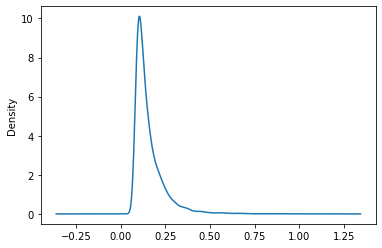

In [89]:
ax=pd.Series([proba.max() for proba in y_train_pred]).plot.kde()

In [90]:
[proba.max() for proba in y_train_pred][0:5]

[0.25024638, 0.12938744, 0.101466216, 0.17512722, 0.10237063]

In [91]:
#https://www.pythonprogramming.in/suppress-scientific-notation-in-numpy.html
np.set_printoptions(suppress=True,
                    formatter={'float_kind': '{:f}'.format})

In [92]:
print(y_train_pred[0])
print(y_train_pred[0].sum())

[0.004727 0.103077 0.106491 0.079234 0.155606 0.093986 0.250246 0.014416
 0.030415 0.011820 0.013174 0.028168 0.046637 0.016595 0.020498 0.004491
 0.005784 0.009245 0.001719 0.003670]
1.0000001


In [93]:
print(y_train_pred[1])
print(y_train_pred[1].sum())

[0.013479 0.121283 0.084501 0.098067 0.074860 0.078526 0.129387 0.050678
 0.039014 0.048457 0.043543 0.028973 0.054259 0.034087 0.042994 0.013272
 0.010879 0.012499 0.009337 0.011903]
1.0


In [94]:
print(y_train_pred[2])
print(y_train_pred[2].sum())

[0.020883 0.100505 0.085632 0.101466 0.066569 0.089038 0.082540 0.033696
 0.070939 0.037555 0.048094 0.039872 0.043503 0.048295 0.043947 0.023354
 0.017644 0.019572 0.013285 0.013611]
1.0


In [95]:
print(y_train_pred[3])
print(y_train_pred[3].sum())

[0.021320 0.079661 0.065591 0.050946 0.084875 0.073334 0.175127 0.044894
 0.046704 0.040197 0.039991 0.042185 0.053770 0.043905 0.035453 0.024071
 0.017386 0.032701 0.012310 0.015580]
1.0000001


In [96]:
print(y_train_pred[4])
print(y_train_pred[4].sum())

[0.038525 0.048273 0.036564 0.043331 0.040502 0.058522 0.022173 0.039897
 0.102371 0.050643 0.097086 0.047605 0.046465 0.064502 0.052574 0.059587
 0.047534 0.046418 0.031622 0.025806]
1.0


In [97]:
print(y_train_pred[5])
print(y_train_pred[5].sum())

[0.025458 0.001067 0.001161 0.000889 0.000558 0.000270 0.000034 0.005950
 0.006087 0.005407 0.020214 0.039318 0.000859 0.036626 0.004083 0.056842
 0.190710 0.540205 0.035738 0.028525]
0.99999994


#### This is how the predicted class is obtained from probabilities

In [98]:
#y_train_pred = [[1 if i>=0.5 else 0 for i in i] for i in y_train_pred]
#y_test_pred  = [[1 if i>=0.5 else 0 for i in i] for i in y_test_pred]

idx = np.argmax(y_train_pred, axis=-1)
y_train_pred = np.zeros( y_train_pred.shape )
y_train_pred[ np.arange(y_train_pred.shape[0]), idx] = 1

idx = np.argmax(y_test_pred, axis=-1)
y_test_pred = np.zeros( y_test_pred.shape )
y_test_pred[ np.arange(y_test_pred.shape[0]), idx] = 1

In [99]:
y_train_pred[0:6]

array([[0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 1.000000, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        1.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
        0.000000, 0.000000],
       [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,


In [100]:
pd.Series([max(class_) for class_ in y_train_pred]).value_counts()

1.0    14024
dtype: int64

In [101]:
pd.Series([max(class_) for class_ in y_test_pred]).value_counts()

1.0    4675
dtype: int64

#### Plot the model2

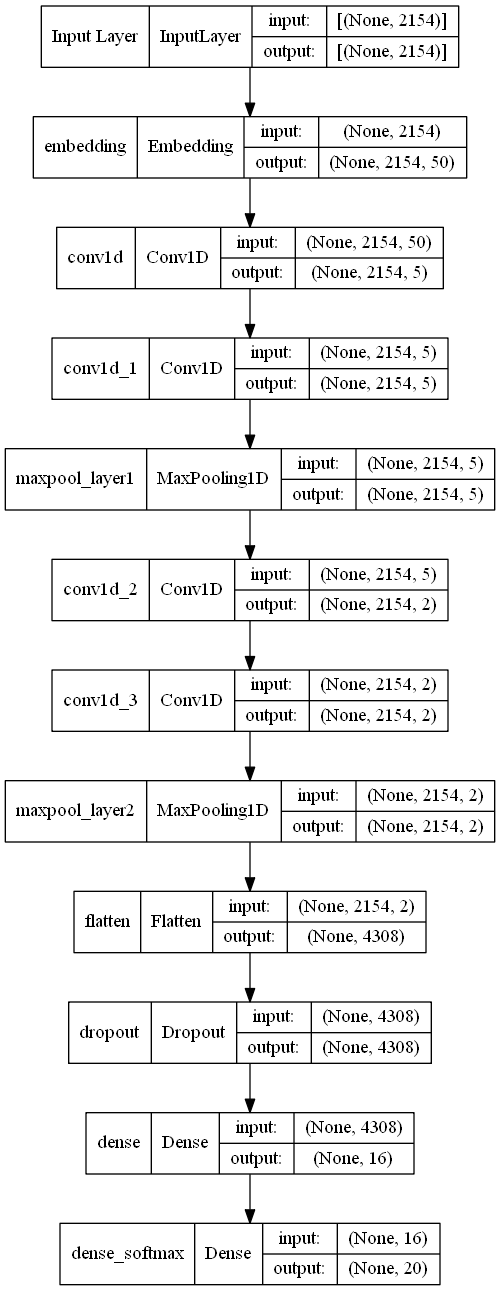

In [103]:
#Plot the Model
#!pip install pydot
#https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model
dot_img_file = './model_2.png'
tf.keras.utils.plot_model(best_model2, to_file=dot_img_file, show_shapes=True)

## Observations

### Model 1
 Covered in the previous notebook, in Part 2

### Model 2

* Always print the results to ensure whether its working the way you expect.
* threshold=0.5 for f1 beta score is removed, let it consider the argmax so that I can see class labels after predictions.
* Since no class is able to be prected since probabilities found are below 0.5 and we find no class predicted, though I find almost 10% accuracy.
* Model highly overfits with kernel size 2; made kernel size 10 for first 2 conv1d and 5 for next 2 conv1d.
* Number of filters for first 2 conv1d are redulced to 5, for next 2 conv1d those are reduced to 2; this is to control overfitting.
* Drop out rate was increased from 0.1 ro 0.3 to control the overfitting.
* Model 2 looks overfitted. Training data has good performance metrics over test data.
* train_acc: 0.219, test_acc: 0.111
* train_fbeta_score: 0.219, test_fbeta_score: 0.111

#### Tensorboard (Red is train and green is test)

In [105]:
from IPython.display import Image

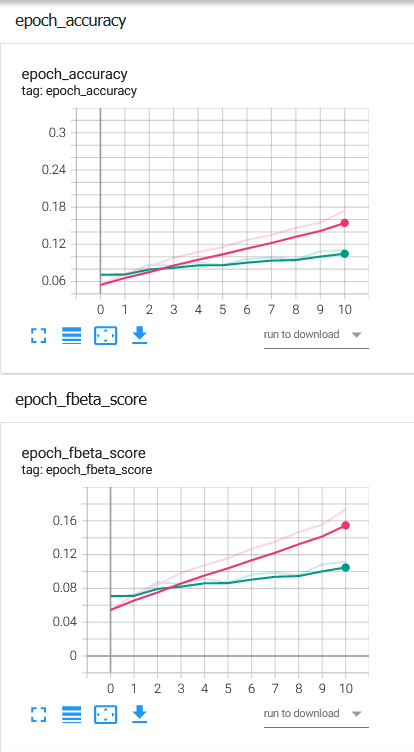

In [106]:
Image("Model 2 - Scalar 1.png")

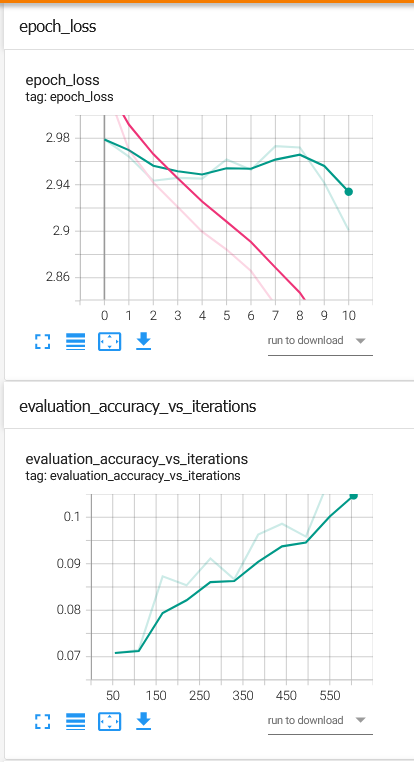

In [107]:
Image("Model 2 - Scalar 2.png")

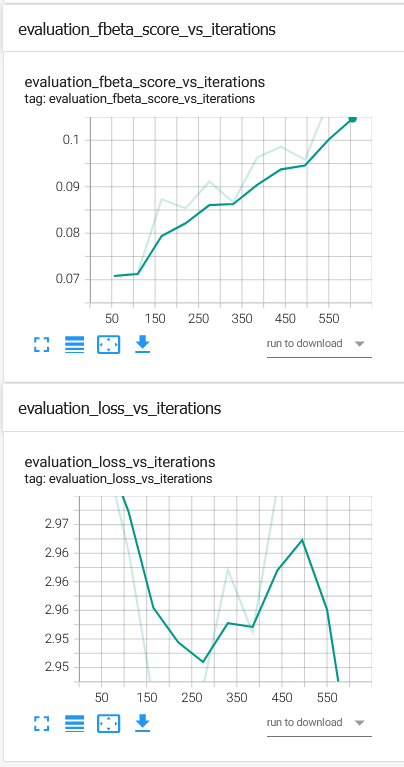

In [108]:
Image("Model 2 - Scalar 3.png")